# Bee ML
This notebook shows a simple model able to improve the daily life of of many beekeepers.

- **DATA:** all data are downloaded from Kaggle (https://www.kaggle.com/se18m502/bee-hive-metrics). In this project I use the data of humity, temperature and weight of the years 2017-2019 of two hives (from Wurzburg and Schwartau).

- **AIM:** The aim of the project is to develop an algorithm able to predict the amount of honey produced by bee in a place in a week. 

- **EVERY DAY LIFE:** For each week we will need the weather forecast for the next week. In the every day life, the beekeeper should use this model to understand which is the best place to leave the hives for the next week. The output of the model is percentage amount of growth of honey in the next week given the weather forecast.

**List of questions for Udacity**

1. Which is relevance of the problem and what could be the relevane of the solution?
1. Which is feasibility of the project? what are the issues to be taken into account and to be underlined?
1. Is the result of model reliable and it is possible to apply it in the daily life of the beekeepers? 

**Answer to question 1.** Everybody knows the famous sentence attributed to Albert Einstein *If the Bee Disappeared Off the Face of the Earth, Man Would Only Have Four Years Left To Live*. Indeed, from decades the importance of the pollination and the benefits of the honey are known by everyone. Instead, not everybody know that, unfortunately from several years the bee are disappearing ([1],[2], and I could cite many others). For such scientific evidences, it will always be increasingly difficult to produce honey and all its derivatives. In this context, this model should stimulate the beekeepers interested in using the technology and the artificial intelligence to improve their production.

In [1]:
# Import libraries
import numpy as np
import pandas as pd

In [2]:
# Read data (https://www.kaggle.com/se18m502/bee-hive-metrics))
humidity_w = pd.read_csv("bee-hive-metrics/humidity_wurzburg.csv")
humidity_s = pd.read_csv("bee-hive-metrics/humidity_schwartau.csv")
temperature_w = pd.read_csv("bee-hive-metrics/temperature_wurzburg.csv")
temperature_s = pd.read_csv("bee-hive-metrics/temperature_schwartau.csv")
weight_w = pd.read_csv("bee-hive-metrics/weight_wurzburg.csv")
weight_s = pd.read_csv("bee-hive-metrics/weight_schwartau.csv")

## Preprocessing 

In [3]:
# This function trasforms the input data taking the min, max, and mean for each day 
def transform_df(df,col):
    """
    This function transfom the data calculating the min, max and mean for 
    each day
    Args:
        df: dataframe to transform
        col: column to group
    Return:
        Transformed dataframe with min, max and mean of col
    """
    df['timestamp'] = pd.to_datetime(df['timestamp'], format="%Y-%m-%d %H:%M:%S")
    df['day'] = df['timestamp'].apply(lambda x: x.day)
    df['month'] = df['timestamp'].apply(lambda x: x.month)
    df['year'] = df['timestamp'].apply(lambda x: x.year)    
    df = df.groupby(['year','month','day']).agg({col:['min','max','mean']}).reset_index()
    df.columns = df.columns.map('_'.join)
    return df

In [4]:
# Transfom all the dataframs
hum_w = transform_df(humidity_w,'humidity')
hum_s = transform_df(humidity_s,'humidity')
tem_w = transform_df(temperature_w,'temperature')
tem_s = transform_df(temperature_s,'temperature')
wei_w = transform_df(weight_w,'weight')
wei_s = transform_df(weight_s,'weight')

In [5]:
# Merge all the data
w_data = (hum_w
          .merge(tem_w, on=['year_','month_','day_'])
          .merge(wei_w, on=['year_','month_','day_'])
          )
s_data = (hum_s
          .merge(tem_s, on=['year_','month_','day_'])
          .merge(wei_s, on=['year_','month_','day_'])
          )
all_data = pd.concat([w_data,s_data]).reset_index(drop=True)

In [6]:
"""
Here I create the dataset for training. The dataset takes 7 days of weather 
information (humidity and temperature) added to columns with months of the data.  
"""
len_window = 7
X =[]
y = []
for i in range(len(all_data)):
    row_i = [all_data.loc[i,'month_']]
    weight_i = all_data.loc[i,'weight_mean']
    if i+len_window>len(all_data): break
    for j in range(len_window):
        row_i= row_i+[all_data.loc[i+j,'humidity_min'],
                             all_data.loc[i+j,'humidity_max'],
                             all_data.loc[i+j,'humidity_mean'],
                             all_data.loc[i+j,'temperature_min'],
                             all_data.loc[i+j,'temperature_max'],
                             all_data.loc[i+j,'temperature_mean']]
        if j == (len_window-1):
            weight_f = all_data.loc[i+j,'weight_mean']
            delta_weight = ((weight_f-weight_i)/weight_i)*100
            if delta_weight>100: delta_weight=100.
            if delta_weight<-100: delta_weight=-100.    
            y.append(delta_weight)
            X.append(row_i)
data_model_full = pd.DataFrame(X)
data_model_full['y'] = pd.Series(y)

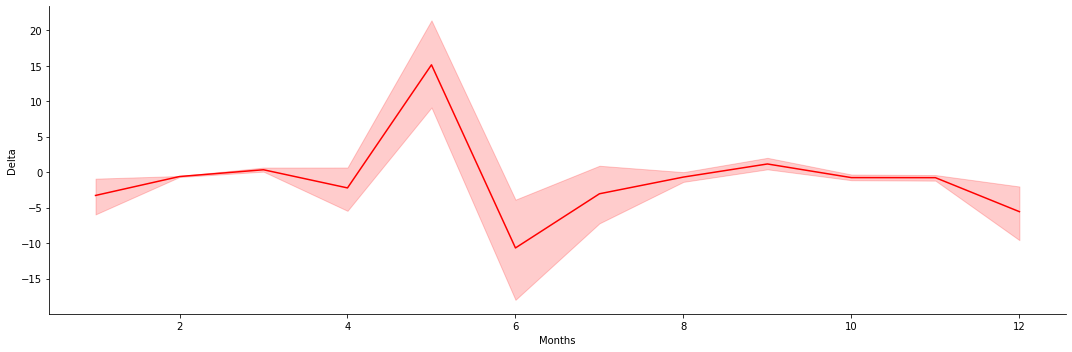

In [7]:
# Plotting target
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.relplot(x=0, y="y", data=data_model_full,height=5,kind="line",aspect=3,color='red')
ax.set(xlabel='Months', ylabel='Delta')
plt.savefig("target.png",dpi=300)
plt.show()

In [8]:
# Drop null values
data_model_full = data_model_full.dropna()

In [9]:
col_name = ["month"]
for day in range(7):
    col_name.append("Hmin_"+str(day))
    col_name.append("Hmax_"+str(day))
    col_name.append("Hmean_"+str(day))
    col_name.append("Tmin_"+str(day))
    col_name.append("Tmax_"+str(day))
    col_name.append("Tmean_"+str(day))
col_name.append("delta_w")    
data_model_full.columns = col_name
data_model_full.head()

,month,Hmin_0,Hmax_0,Hmean_0,Tmin_0,Tmax_0,Tmean_0,Hmin_1,Hmax_1,Hmean_1,...,Tmin_5,Tmax_5,Tmean_5,Hmin_6,Hmax_6,Hmean_6,Tmin_6,Tmax_6,Tmean_6,delta_w
0,1,90.945000,93.768333,92.058947,-5.1744,6.050467,-0.082160,92.130000,93.533333,92.794722,...,-8.7460,18.896000,-0.937771,81.615000,93.590000,89.077361,-10.0720,9.365183,-2.648782,-0.525869
1,1,92.130000,93.533333,92.794722,-2.4640,8.452600,1.825578,87.871667,92.716667,91.173472,...,-10.0720,9.365183,-2.648782,89.520000,90.816667,90.131181,-3.8698,7.731600,1.812449,-0.040630
2,1,87.871667,92.716667,91.173472,-0.5704,10.064000,3.082557,88.841667,93.055000,91.077917,...,-3.8698,7.731600,1.812449,89.081667,90.948333,90.166528,0.6620,9.885500,3.659525,-0.067327
3,1,88.841667,93.055000,91.077917,-0.6370,9.798667,3.750071,75.839333,89.576667,82.656076,...,0.6620,9.885500,3.659525,82.250000,89.778333,86.372014,-1.4738,13.534500,4.034587,-0.068585
4,1,75.839333,89.576667,82.656076,-4.6214,9.566917,2.259225,87.911667,93.686667,91.545347,...,-1.4738,13.534500,4.034587,84.926667,91.686667,87.873681,-0.1502,11.806167,4.752350,-0.281404


In [10]:
data_model_full.shape

(1580, 44)

**Answer to question 2.** The data are relative to two hives for the years 2017-2019. After the preprocessing I obtained a dataset of features of shape (1580,43). At this point I have two sources of concern. The first one: I only have data about two hives, and this is clearly low because it provides me the statistics about only two locations. The second concern is about the weather data. Indeed, for the training I have the real data measured inside the hives, however for scoring I should use weather forecast data. In this notebook, I do not test the model with weather forecast data.

Instead, the figure above shows the variation of $\Delta$ during the months. The figure shows the decreasing of honey in the winter and an increasing in spring (specially May). Interesting and important to underlying is the strong decrease of honey in June. This is probably due by the collection of honey by the beekeeper in that period. This should be a problem for the model, because, actually, the bee in that period are producing a lot of honey. However my target is showing a strong decrease of honey. In the future, a solution for that problem could be to leave one hive for location with honey for all the season. In that way I should understand the natural behavior of the hives in that period.

In [11]:
# Division in features and target
X = data_model_full.drop('delta_w',axis=1)
y = data_model_full['delta_w']

In [12]:
# Standard scalar for features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [13]:
# Libraries for different models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [14]:
# Divide in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [15]:
# Function for train the model and optimize the parameters
def train_model(model,param,n_cv,X,y):
    """
    This function train the model
    Args:
        model: sklearn model
        param: dictionary with parameters for the Grid Search
        n_cv: number of folds for the cross validation
        X: features
        y: target
    Return:
        Trained model
    """
    gs = GridSearchCV(model, param,cv=n_cv,n_jobs=-1)
    gs.fit(X,y)
    return gs

In [16]:
from sklearn.metrics import mean_squared_error
def evaluate_regressor(model,y_true,y_pred):
    """
    This function evaluates the regressor with the root mean square error
    Args:
        model: sklearn model to evaluate
        y_true: true data
        y_pred: predicted data
    Return:
        Root mean square error
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse     

## Modelling

In [17]:
# Gradient Boosting
gbr = GradientBoostingRegressor()
parameters_gb ={"learning_rate":[0.1],
                "n_estimators":[30],
                "min_samples_split":[2,4,8],
                "min_samples_leaf":[1,5],
                "max_depth":[3,5,10]
               }
model = train_model(gbr,parameters_gb,5,X_train,y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
rmse_train = evaluate_regressor(model,y_train,y_pred_train)
rmse_test = evaluate_regressor(model,y_test,y_pred_test)
print(rmse_train,rmse_test)

5.889004061231692 19.394047990141047


In [18]:
# Linear model
from sklearn.linear_model import Ridge
ridge = Ridge()
parameters_ridge={"alpha":[1.0,1.2,0.5],
               }
model = train_model(ridge,parameters_ridge,5,X_train,y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
rmse_train = evaluate_regressor(model,y_train,y_pred_train)
rmse_test = evaluate_regressor(model,y_test,y_pred_test)
print(rmse_train,rmse_test)

18.74510801988328 22.397383257269844


In [19]:
# Polynomial regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
pol = PolynomialFeatures(degree=2)
X_train_p = pol.fit_transform(X_train)
X_test_p = pol.fit_transform(X_test)
lm = LinearRegression()
parameters_lm={}
model = train_model(lm,parameters_lm,2,X_train,y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
rmse_train = evaluate_regressor(model,y_train,y_pred_train)
rmse_test = evaluate_regressor(model,y_test,y_pred_test)
print(rmse_train,rmse_test)

18.738081793640532 23.52098172104173


In [ ]:
# Random Forest
rfr = RandomForestRegressor()
parameters_rfr ={"n_estimators":[100],
                "min_samples_split":[2,4,8],
                "min_samples_leaf":[1,5],
                "max_depth":[None,3,5],
                 "max_features":["auto","sqrt",4,2],
                 "random_state":[1029]
               }
model = train_model(rfr,parameters_rfr,3,X_train,y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
rmse_train = evaluate_regressor(model,y_train,y_pred_train)
rmse_test = evaluate_regressor(model,y_test,y_pred_test)
print(rmse_train,rmse_test)

In [ ]:
# Best parameters
model.best_params_

In [ ]:
"""
The graph shows the concordance between the prevision of increase or
decrease of honey of the model  and the real values. When both model and real
data show an increase of honey in the next week the values is
equal to 1. Instead when there is a divergence about the prevision 
and the reality the values are equal to -1.
"""
import seaborn as sns
import matplotlib.pyplot as plt
y_pred_test_series = pd.Series(y_pred_test)
y_test_series = y_test.reset_index(drop=True)
month = pd.Series(sc.inverse_transform(X_test)[:,0])
df_predicted = pd.DataFrame()
df_predicted["true"] = y_test_series
df_predicted["predicted"] = y_pred_test
df_predicted["month"] = month
df_predicted["signal"] =  y_test_series*y_pred_test/abs(y_test_series*y_pred_test)
df_predicted = df_predicted.sort_values(by=["month"]).reset_index(drop=True)
plt.figure(figsize=(20,4))
sns.relplot(x='month', y='signal',
            data=df_predicted,
            kind="line",
            height=5,
            aspect=3)
ax.set(xlabel='Months', ylabel='Concordace')
plt.savefig("concordance.png",dpi=300)

**Answer to question 3.**
The $RMSE$ is 18. This means that when I am scoring I should take into account that I may be doing an error of 18\%, and therefore only dislocate the hives if I have an inference of production in a place that is 18\% bigger than the other places. 

Instead, the figure above shows the correlation between the the estimations of increasing and decreasing of honey. The figure shows that the correlation is high from October to July and it is low in the other months. From that I can conclude that it is better to no trust the model in that months, while the model is trustable in the others. 

## Conclusion
From testing different models, the random forest regression tourned out the best model with an $RMSE=18.2$. The graph shows an high accuracy from October to July, while a bad accuray in August and September. I believe this fact is due to the human intervention done in the hives during this period.

## References

[1]: Jessica Hamzelou. Where have all the bees gone? 2007

[2]: Rosa, J. M.,Arioli C. J.,Nunes-Silva P.,Garcia F. R. M.. Disappearance of pollinating bees in natural and agricultural systems: is there an explanation?